In [1]:
#Import relevant modules
import pygsti
import rb
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as _np
from pygsti.construction import std1Q_XYI
from scipy.optimize import curve_fit
import time

In [2]:
import pygsti

In [3]:
#Declare target gate set (here, we're using standard {I, X(pi/2), Y(pi/2)} gate set)
gs_target = std1Q_XYI.gs_target

In [4]:
#Declare a "primitives dictionary".  Here the primitives are the actual
#gate operations {I, X(pi/2), Y(pi/2)}.  The Clifford operations are
#expressed using the larger gate set of {I, X(pi/2), X(pi), X(-pi/2), Y(pi/2), Y(pi), Y(-pi/2)}.
#We call this larger gate set the "canonical gate set" and declare here a dictionary
#mapping the canonical gate set to primitive gate operations.
primD = {'Gi':['Gi'],'Gxp2':['Gx'],'Gxp':['Gx','Gx'],'Gxmp2':['Gx','Gx','Gx'],
          'Gyp2':['Gy'],'Gyp':['Gy','Gy'],'Gymp2':['Gy','Gy','Gy']}

In [5]:
#Now let's declare:
#m_min- minimum Clifford sequence length
#m_max- maximum Clifford sequence length
#delta_m- step size between Clifford sequences of different lengths
#K_m_sched- Schedule for K_m, that is, how many sequences should be sampled with Clifford length m.
#Note that K_m_sched can be a constant or an OrderedDict.

#Here we are declaring K_m_sched to be a constant, meaning that K_m is a single constant for all m.
#See RB-Tutorial-2 for use of K_m as an OrderedDict.

m_min = 1
m_max = 1000
delta_m = 10
K_m_sched = 10

In [6]:
#Now we will generate the list of RB sequences to run (in terms of primitive gate
#operations), write them to file, and write 
#an auxiliary file which keeps track of the Clifford length of each primitive gate sequence.

filename_base = 'RB-Tutorial-1_template'
rb_seqs, cliff_lens = rb.write_empty_rb_files(filename_base,1,1000,100,K_m_sched,'primitive',primD,seed=0)

#Because K_m_sched is a constant, we cannot use Wallman and Flammia error bars; the code warns us
#accordingly.

K_m_sched is not an OrderedDict, so Wallman and Flammia error bars are not valid.


In [7]:
#There is now an empty template file "RB-Tutorial-1_template.txt".  
#For actual physical experiments, this file is to be filled with
#experimental data and read in using pygsti.io.load_dataset.

#Here we will generate fake data instead and just use the resulting dataset object.

#Additionally, there is now a pickle file "RB-Tutorial-1_template_cliff_seq_lengths.pkl"
#which lists in order the Clifford length of each sequence.
#For analyzing experimental data, this pickle file should be read in, 
#or the above-declared cliff_lens list should be used.

In [8]:
#To generate a dataset, we first need to make a gateset.
#Here we assume a gate set that is perfect except for some small amount of depolarizing noise on each gate.

depol_strength = 1e-3

gs_experimental = std1Q_XYI.gs_target
gs_experimental = gs_experimental.depolarize(gate_noise=depol_strength)

In [9]:
#Now we choose the number of clicks per experiment and simulate our data.
#Note that time to generate simulated data can be nontrivial.  
#Here, it should take about 1 second.

N=100

start = time.time()
rb_data = pygsti.construction.generate_fake_data(gs_experimental,rb_seqs,N,'binomial',seed=1)
end = time.time()
print end - start

1.1076939106


In [10]:
#Now it is time to analyze the RB data.
#After analyzing the data, an rb_results object is generated.
#We extract the relevant parameters we care about from the rb_results object.

#We set the following keyword arguments here:
#prim_dict = primD.  Declares the predefined dictionary mapping the "canonical" gate set to our primitive gate set.
#pre_avg = True.  Are we, prior to fitting to the RB decay curve, "pre-averaging" the data?  That is, are we
#using a single survival probability per sequence length or not?  For now I recommend keeping this set to True.
#process_cliff = True.  Whether or not we actually perform the RB analysis for Clifford operations.
#process_prim = True.  Whether or not we actually perform the RB analysis for primitive operations.  
#NOTE:  RB IS NOT GUARANTEED TO GIVE RELIABLE PRIMITIVE ANALYSIS (and in general will not!).

rb_results = rb.process_rb_data(rb_data,rb_seqs,cliff_lens,prim_dict=primD,pre_avg=True,process_prim=True,process_cliff=True)

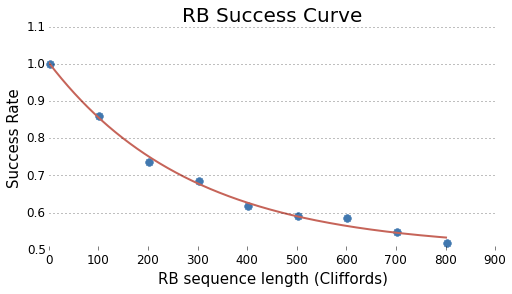

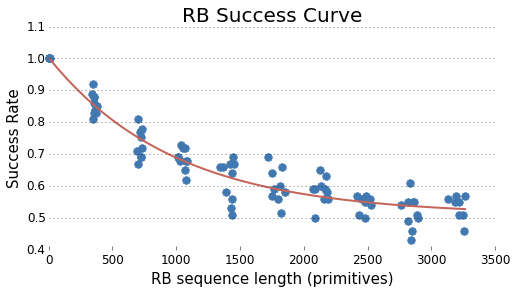

In [11]:
#Let's plot our decay curves!
#Note that because we pre-averaged, each data blue data point is simply an average of multiple success rates.
#However, for the primitives plot, many sequences have a unique primitive sequence length, so this effect is not
#nearly as pronounced.
rb_results.plot('cliff')

rb_results.plot('prim')

In [12]:
#Let's look at the RB results.  The parameters are defined as follows, following Wallman and Flammia 
#(http://iopscience.iop.org/article/10.1088/1367-2630/16/10/103032)

#A,B,f are fit parameters to the function F(m) = A+B*f^m, where F(m) is the survival probability for sequences of length m.
#F_avg = ((d-1)*f+1.)/d, where for n=1 qubit, d=2.  F_avg is the average (Clifford or primitive) gate fidelity.
#r = 1-F_avg.  For Cliffords, r is the "RB number."
rb_results.print_cliff()
print
rb_results.print_prim()

For Cliffords:
A = 0.501936460141
B = 0.501276979413
f = 0.99653292489
F_avg = 0.998266462445
r = 0.00173353755525

For primitives:
A = 0.509627246508
B = 0.492877234975
f = 0.998988252715
F_avg = 0.999494126357
r = 0.000505873642596


In [13]:
#Because we generated our data from a known Markovian gate set, we can analytically compute
#the Clifford RB error rate r.

#First we make map our experimental gate set of primitive operations into a dictionary of Cliffords:

gs_cliff_experimental = rb.makeRealCliffs_gs(gs_experimental,primD)

#Then we directly compute the average twirled Clifford error rate:

analytic_rb_error_rate = rb.analytic_rb_cliff_gateset_error_rate(gs_cliff_experimental)

print "Analytic RB error rate:", analytic_rb_error_rate
print "Experimental RB error rate:", rb_results.cliff_r

Analytic RB error rate: 0.00176791958146
Experimental RB error rate: 0.00173353755525


In [14]:
#Lastly, let's put some error bars on the estimates.
#Because we used a constant K_m_sched, we can't compute analytic error bars using the Wallman and Flammia method.
#We can instead, however, compute bootstrapped error bars.
#Error bars here are 1-sigma confidence intervals.

rb_results.generate_error_bars('bootstrap',process_cliff=True,process_prim=True,seed=0)

Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-param

In [16]:
#Now that we've generated bootstrapped error bars, let's print them:
rb_results.error_bars('bootstrap',process_cliff=True,process_prim=True)

Results with boostrapped-derived error bars (1 sigma):
prim A = 0.509627246508 +/- 0.0141652466138
prim B = 0.492877234975 +/- 0.0143866494649
prim f = 0.998988252715 +/- 8.15473715307e-05
prim F_avg = 0.999494126357 +/- 4.07736857654e-05
prim r = 0.000505873642596 +/- 4.07736857654e-05
Cliff A = 0.501936460141 +/- 0.0170652277287
Cliff B = 0.501276979413 +/- 0.0163594586634
Cliff f = 0.99653292489 +/- 0.000301291173574
Cliff F_avg = 0.998266462445 +/- 0.000150645586787
Cliff r = 0.00173353755525 +/- 0.000150645586787


In [17]:
#We can also manually extract the error bars now; for example:

print rb_results.cliff_r_error_BS

0.000150645586787
